In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2



In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


In [3]:
# run_config_name = sys.argv[1]
run_config_name = 'run_test_128_condFPM_uniformcic_fof_lgMmin5e13_wL2norm_highknots.yaml'

with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)






In [4]:
config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
subsel_highM1 = config_sims['subsel_highM1']
nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp

df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, ind_subsel_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_highM1=subsel_highM1, nsubsel=nsubsel
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
    )



In [5]:
if cond_sim == 'fastpm':
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, ind_subsel_train_FP = load_density_halo_data_NGP(
        ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm', subsel_highM1=subsel_highM1, ind_subsel=ind_subsel_train
        )

    # # Prepare the density and halo data
    return_dict_train_FP = prep_density_halo_cats_batched(
        df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
        nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
else:
    return_dict_train_FP = None







In [6]:
# len(ind_subsel_train_FP), len(ind_subsel_train)
return_dict_train.keys()
# df_d_all_train.shape
# ji_array




dict_keys(['df_d_all', 'df_d_all_nsh', 'M_halos_all_sort_norm', 'Mmin', 'Mmax', 'Nmax', 'mask_M_diff', 'mask_M1', 'M1_halos_all_norm', 'M_diff_halos_all_norm_masked', 'Nhalo_train_mg_arr', 'N_halos_all', 'mu_all', 'sig_all', 'ngauss_Nhalo'])

In [7]:
# return_dict_train['df_d_all'].shape, return_dict_train_FP['df_d_all'].shape
# return_dict_train['M_halos_all_sort_norm'].shape, return_dict_train_FP['M_halos_all_sort_norm'].shape
# return_dict_train['M_diff_halos_all_norm_masked'].shape
return_dict_train['df_d_all_nsh'][0,:,0,...].shape, return_dict_train['N_halos_all'][0,...].shape


((512, 16, 16, 16), (512, 4096))

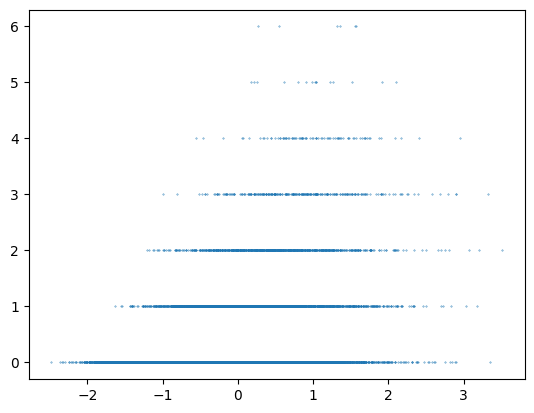

In [30]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['N_halos_all'][0,...].flatten()[::100], s=0.1)


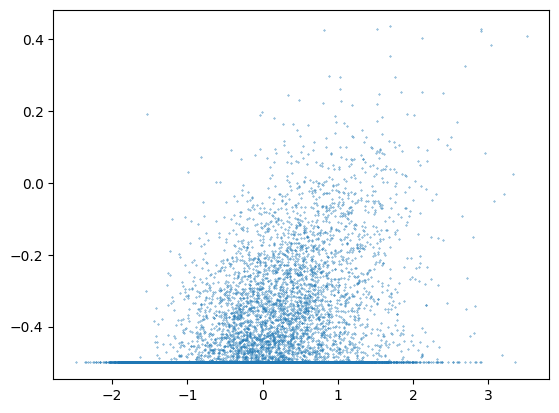

In [31]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['M1_halos_all_norm'][0,...].flatten()[::100], s=0.1)



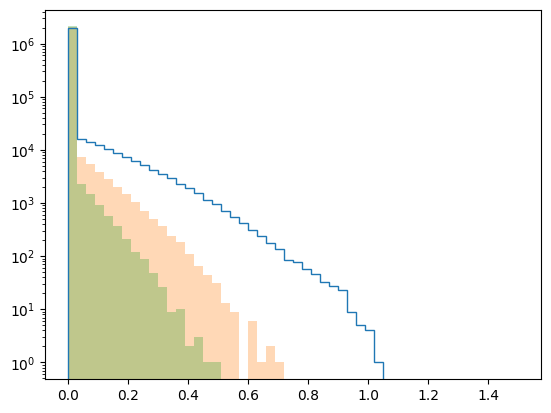

In [13]:
pl.figure()
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,0].flatten(), bins=50, range=(0,1.5), histtype='step', label='z=0')
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,1].flatten(), bins=50, range=(0,1.5), alpha=0.3)
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,2].flatten(), bins=50, range=(0,1.5), alpha=0.3)
pl.yscale('log')


In [32]:
return_dict_train['df_d_all'].shape

(1, 512, 4, 24, 24, 24)

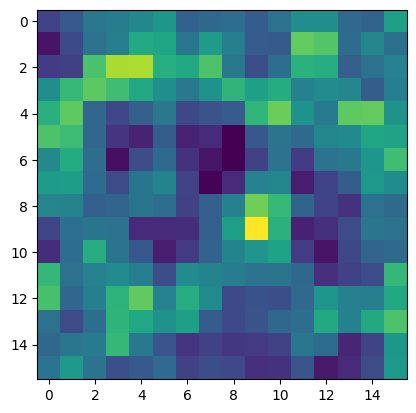

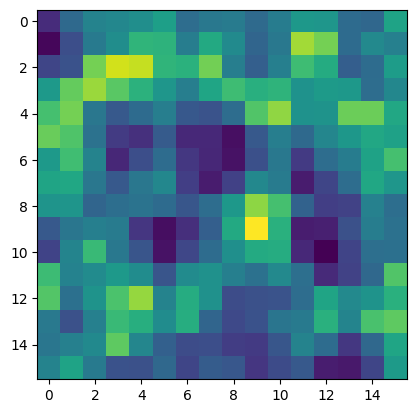

In [33]:
indp = 109

pl.figure()
pl.imshow(return_dict_train['df_d_all_nsh'][0,indp, 0, 8, :, :])
pl.figure()
pl.imshow(return_dict_train_FP['df_d_all_nsh'][0,indp, 0, 8, :, :])



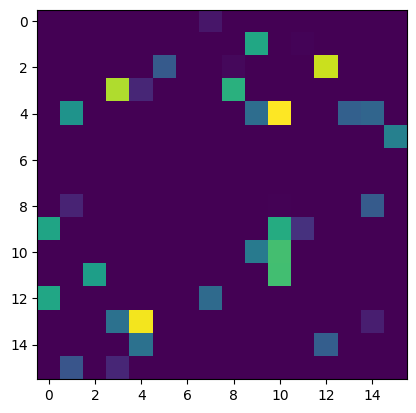

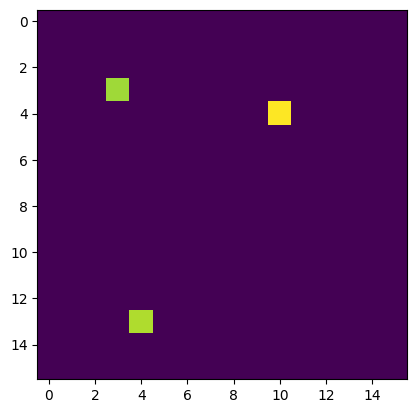

In [34]:
# indp = 10
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.figure()
pl.imshow(return_dict_train['M_halos_all_sort_norm'][0,indp,:, 0].reshape(16,16,16)[8,:,:])
pl.figure()
pl.imshow(return_dict_train_FP['M_halos_all_sort_norm'][0,indp,:,0].reshape(16,16,16)[8,:,:])



In [7]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


# num_cond_Ntot = num_cond
# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()


In [8]:
# base_dist_Ntot


In [9]:
from torch.utils.data import DataLoader, Dataset
# class LoadCustomData(Dataset):
#     def __init__(self, return_dict, return_dict_FP, all_gpu=False):
#         if return_dict_FP is not None:
#             self.cond_tensor = torch.Tensor(np.array(return_dict_FP['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict_FP['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
#         else:
#             self.cond_tensor = torch.Tensor(np.array(return_dict['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

#         self.mask_tensor_M1_train = torch.Tensor(np.array(return_dict['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#         self.mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

#         self.X_M1 = torch.Tensor((np.array(return_dict['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Nhalo = torch.Tensor(np.array(return_dict['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Mdiff = torch.Tensor(np.array(return_dict['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
#         self.Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

#         if return_dict_FP is not None:
#             self.mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#             self.X_M1_FP = torch.Tensor((np.array(return_dict_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         else:
#             self.mask_tensor_M1_train_FP = None
#             self.X_M1_FP = None
#         if all_gpu:
            # self.cond_tensor = self.cond_tensor.cuda(dev)
            # self.cond_tensor_nsh = self.cond_tensor_nsh.cuda(dev)
            # self.mask_tensor_M1_train = self.mask_tensor_M1_train.cuda(dev)
            # self.mask_tensor_Mdiff_train = self.mask_tensor_Mdiff_train.cuda(dev)
            # self.X_M1 = self.X_M1.cuda(dev)
            # self.X_Nhalo = self.X_Nhalo.cuda(dev)
            # self.X_Mdiff = self.X_Mdiff.cuda(dev)
            # self.Nhalos_truth_tensor = self.Nhalos_truth_tensor.cuda(dev)
            # if return_dict_FP is not None:
            #     self.mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP.cuda(dev)
            #     self.X_M1_FP = self.X_M1_FP.cuda(dev)

#     def __len__(self):
#         return len(self.cond_tensor)

#     def __getitem__(self, idx):
#         cond_tensor = (self.cond_tensor[idx,...])
#         cond_tensor_nsh = self.cond_tensor_nsh[idx,...]
#         mask_tensor_M1_train = self.mask_tensor_M1_train[idx,...]
#         mask_tensor_Mdiff_train =self.mask_tensor_Mdiff_train[idx,...]
#         X_M1 = self.X_M1[idx,...]
#         X_Nhalo = self.X_Nhalo[idx,...]
#         X_Mdiff = self.X_Mdiff[idx,...]
#         Nhalos_truth_tensor = self.Nhalos_truth_tensor[idx,...]
#         if self.mask_tensor_M1_train_FP is not None:
#             mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP[idx,...]
#             X_M1_FP = self.X_M1_FP[idx,...]
#         else:
#             mask_tensor_M1_train_FP = torch.Tensor([-9999])
#             X_M1_FP = torch.Tensor([-9999])

#         return (cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, X_Nhalo,
#                  X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP)


ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None

    
cond_tensor = cond_tensor.cuda(dev)
cond_tensor_nsh = cond_tensor_nsh.cuda(dev)
mask_tensor_M1_train = mask_tensor_M1_train.cuda(dev)
mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.cuda(dev)
X_M1 = X_M1.cuda(dev)
X_Nhalo = X_Nhalo.cuda(dev)
X_Mdiff = X_Mdiff.cuda(dev)

# mask_tensor_M1_train = None
# mask_tensor_Mdiff_train = None
# X_M1 = None
# X_Mdiff = None

Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = mask_tensor_M1_train_FP.cuda(dev)
    X_M1_FP = X_M1_FP.cuda(dev)
    
    




In [10]:
# torch.amin(Nhalos_truth_tensor), torch.amax(Nhalos_truth_tensor), return_dict_train['mu_all']
X_M1_FP

tensor([[[-0.5000],
         [-0.5000],
         [-0.5000],
         ...,
         [-0.5000],
         [-0.5000],
         [-0.5000]]], device='cuda:0')

In [11]:
# # X_Nhalo.shape, cond_tensor_nsh.shape
# np.array(return_dict_train['N_halos_all']).shape, cond_nsh.shape, np.array(return_dict_train['M1_halos_all_norm']).shape

# Nhalos_3d = np.array(return_dict_train['N_halos_all']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# Mhalos_3d = np.array(return_dict_train['M1_halos_all_norm']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# delta_m_3d = cond_nsh[...,0]




In [12]:
# # make a three panel plot
# import matplotlib.pyplot as pl
# import matplotlib
# %matplotlib inline
# indsim = 300
# pl.figure()
# pl.subplot(131)
# pl.imshow(Nhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(132)
# pl.imshow(Mhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(133)
# pl.imshow(delta_m_3d[0,indsim,0,...])
# # pl.colorbar()


In [13]:

# delta_m = cond_tensor_nsh[0,:,0].cpu().numpy()
# Nhalo = X_Nhalo[0,:,0].cpu().numpy()
# indsel = np.where((delta_m > 3) & (delta_m < 100))[0]
# pl.figure()
# pl.scatter(delta_m[indsel], Nhalo[indsel], s=0.1)


In [14]:
# np.amin(delta_m), np.amax(delta_m), np.amin(Nhalo), np.amax(Nhalo)



In [10]:
with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_TEST_FINALS_SIMPLE_BATCHED_model_save_nsim' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim + \
#                             '_nsd' + str(ns_d) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train) + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_SUBSEL_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_plexp_ns_' + str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                            '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)

# start_with_bestfit = config_train['start_with_bestfit']

# if start_with_bestfit:
#     try:
#         print('loading bestfit model')
#         bestfit_model = (torch.load(save_bestfit_model_name))
#         model.load_state_dict(bestfit_model['state_dict'])
#         optimizer.load_state_dict(bestfit_model['optimizer'])
#         scheduler.load_state_dict(bestfit_model['scheduler'])
#         loss_min = bestfit_model['loss_min']
#         loss = bestfit_model['loss']
#         lr = bestfit_model['lr']
#         epoch_tot_counter = bestfit_model['epoch_tot_counter']
#         for g in optimizer.param_groups:
#             # g['lr'] = lr
#             g['lr'] = 0.01          

#     except:
#         print('no bestfit model found, running new')
#         pass
#         epoch_tot_counter = 0


# dataset = LoadCustomData(return_dict_train, return_dict_train_FP, all_gpu=all_gpu)
# dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=1 - all_gpu, num_workers=1)




/mnt/home/spandey/ceph/AR_NPE/TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_plexp_ns_10_cond_sim_fastpm_nc4_mass_fof_KM1_10_stype_uniform_cic_L2normNtothist_True_L2normM1hist_True True


In [11]:
# X_M1_FP_jd


In [12]:
# print(loss)
# num_cond_M1


In [13]:
nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']


# nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only, nepochs_all]
# train_Ntot_array = [1, 1, 1]
# train_M1_array = [0, 1, 1 ]
# train_Mdiff_array = [0, 0, 1]

nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only]
train_Ntot_array = [1, 1]
train_M1_array = [0, 1]
train_Mdiff_array = [0, 0]

for jf in range(nflows_train):
# for jf in np.arange(7,16):    
    try:
        epoch_tot_counter = 0
        num_cond_Ntot = num_cond
        
        model_Ntot = SumGaussModel(
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_Ntot,
            ngauss=return_dict_train['ngauss_Nhalo'],
            mu_all=return_dict_train['mu_all'],
            sig_all=return_dict_train['sig_all'],
            base_dist=base_dist_Ntot   
            )

        num_cond_M1 = num_cond + 1
        # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
        if cond_sim == 'fastpm':
            num_cond_M1 += 2

        model_M1 = NSF_M1_CNNcond(
            K=K_M1,
            B=B_M1,
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_M1,
            nflows=nflows_M1_NSF,
            base_dist=base_dist_M1,
            ngauss=ngauss_M1,
            lgM_rs_tointerp=lgM_rescaled,
            hmf_pdf_tointerp=hmf_pdf,
            hmf_cdf_tointerp=hmf_cdf    
            )

        # ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
        # num_cond_Mdiff = num_cond + 2
        # model_Mdiff = NSF_Mdiff_CNNcond(
        #     dim=ndim_diff,
        #     K=K_Mdiff,
        #     B=B_Mdiff,
        #     hidden_dim=hidden_dim_MAF,
        #     num_cond=num_cond_Mdiff,
        #     nflows=nflows_Mdiff_NSF,
        #     base_dist=base_dist_Mdiff,
        #     mu_pos=True
        #     )

        ndim = ndim_diff + 1
        model = COMBINED_Model(
            None,
            None,
            # None,
            model_M1,
            model_Ntot,
            ndim,
            ksize,
            ns_d,
            ns_h,
            nb,
            ninp,
            nfeature_cnn,
            nout_cnn,
            layers_types=layers_types,
            act='tanh',
            padding='valid',
            sep_Ntot_cond=True,
            sep_M1_cond=True,
            sep_Mdiff_cond=True,
            num_cond_Ntot = num_cond_Ntot,
            num_cond_M1 = num_cond_M1,
            num_cond_Mdiff = None
            )

        model.to(dev)

        print()

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_all_it = []
        loss_min = 1e20
        epoch_tot_counter = 0
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)



        save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
        for jn in (range(len(nepochs_array))):
            for g in optimizer.param_groups:
                g['lr'] = 0.001        
            loss_min = 1e20
            torch.cuda.empty_cache()
            ninit = 0
            nepochs = nepochs_array[jn]
            if nepochs > 0:
                train_Ntot = train_Ntot_array[jn]
                train_M1 = train_M1_array[jn]
                train_Mdiff = train_Mdiff_array[jn]

                # if jn > 0:
                #     print('loading bestfit model')
                #     bestfit_model = (torch.load(save_bestfit_model_name))
                #     model.load_state_dict(bestfit_model['state_dict'])
                #     optimizer.load_state_dict(bestfit_model['optimizer'])
                #     scheduler.load_state_dict(bestfit_model['scheduler'])
                #     # loss_min = bestfit_model['loss_min']
                #     loss = bestfit_model['loss']
                #     lr = bestfit_model['lr']
                #     for g in optimizer.param_groups:
                #         g['lr'] = learning_rate

                for jt in tqdm(range(nepochs)):
                    # for jd in range(len(dataloader)):
                    torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
                        X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                                X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

                    if cond_sim == 'quijote':               
                        mask_tensor_M1_train_FP_jd = None
                        X_M1_FP_jd = None
                    
                    torch.cuda.empty_cache()
                    # if 1-all_gpu:
                    # cond_tensor_jd = cond_tensor_jd.cuda(dev)
                    # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
                    # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
                    # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
                    # X_M1_jd = X_M1_jd.cuda(dev)
                    # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
                    # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
                    # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
                    # if mask_tensor_M1_train_FP_jd is not None:
                    #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
                    #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
                    # torch.cuda.empty_cache()

                    
                    loss = model(
                        X_Mdiff_jd,
                        X_M1_jd,
                        X_Nhalo_jd,
                        cond_x=cond_tensor_jd,
                        cond_x_nsh=cond_tensor_nsh_jd,
                        mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
                        mask_M1_truth_all=mask_tensor_M1_train_jd,
                        Nhalos_truth_all=Nhalos_truth_tensor_jd,
                        use_Ntot_samples=False,
                        use_M1_samples=False,
                        train_Ntot=train_Ntot,
                        train_M1=train_M1,
                        train_Mdiff=train_Mdiff,
                        # x_Mdiff_FP=X_Mdiff_FP,
                        x_M1_FP=X_M1_FP_jd,
                        # x_Ntot_FP=X_Nhalo_FP,
                        # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
                        # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
                        mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
                        L2norm_Ntothist=L2norm_Ntothist,
                        L2norm_M1hist=L2norm_M1hist        
                        )

                    loss.backward()
                    optimizer.step()
                    scheduler.step(loss)
                    epoch_tot_counter += 1
                    if (np.mod(jt, int(nepochs / 10)) == 0) or (jt == nepochs - 1):
                        if float(loss.cpu().detach().numpy()) < loss_min:
                            loss_min = float(loss.cpu().detach().numpy())
                            print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                                'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                                'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
                            lr=optimizer.param_groups[0]['lr']
                            # print(loss_min, lr)
                            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                                    'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

                            torch.save(
                                state, save_bestfit_model_name
                                )
    except:
        print('failed at flow:', jf)
        pass





  0%|          | 1/2000 [00:00<11:37,  2.87it/s]

saving bf at: , with loss: 73.10574 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 202/2000 [00:38<05:37,  5.33it/s]

saving bf at: , with loss: 8.90526 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 402/2000 [01:16<05:00,  5.32it/s]

saving bf at: , with loss: 1.64215 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [01:54<04:23,  5.32it/s]

saving bf at: , with loss: 0.04916 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 802/2000 [02:33<03:45,  5.30it/s]

saving bf at: , with loss: -0.46691 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1002/2000 [03:11<03:06,  5.34it/s]

saving bf at: , with loss: -0.57105 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 55%|█████▍    | 1094/2000 [03:29<02:53,  5.22it/s]


failed at flow: 0



  0%|          | 1/2000 [00:00<05:50,  5.71it/s]

saving bf at: , with loss: 50.94564 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 202/2000 [00:38<05:37,  5.33it/s]

saving bf at: , with loss: 10.55158 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 402/2000 [01:16<04:59,  5.34it/s]

saving bf at: , with loss: 2.43978 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [01:54<04:21,  5.35it/s]

saving bf at: , with loss: -0.01511 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 802/2000 [02:33<03:44,  5.33it/s]

saving bf at: , with loss: -0.56619 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1002/2000 [03:11<03:06,  5.35it/s]

saving bf at: , with loss: -0.74897 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 70%|███████   | 1401/2000 [04:28<03:01,  3.30it/s]

saving bf at: , with loss: -0.86091 , at epoch: 1400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1401


 76%|███████▋  | 1525/2000 [04:51<01:27,  5.43it/s]

Epoch 01524: reducing learning rate of group 0 to 5.0000e-04.


 80%|████████  | 1602/2000 [05:06<01:14,  5.35it/s]

saving bf at: , with loss: -0.96223 , at epoch: 1600 learning rate: 0.0005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1601


 97%|█████████▋| 1940/2000 [06:10<00:11,  5.40it/s]

Epoch 01939: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 1/2000 [00:00<15:10,  2.20it/s]

saving bf at: , with loss: 0.68154 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


 10%|█         | 201/2000 [03:17<28:57,  1.04it/s]

saving bf at: , with loss: -0.40035 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 17%|█▋        | 340/2000 [05:32<26:24,  1.05it/s]

Epoch 02340: reducing learning rate of group 0 to 5.0000e-04.


 20%|██        | 401/2000 [06:32<25:34,  1.04it/s]

saving bf at: , with loss: -0.54116 , at epoch: 400 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2401


 30%|███       | 601/2000 [09:48<22:29,  1.04it/s]

saving bf at: , with loss: -0.54274 , at epoch: 600 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2601


 37%|███▋      | 741/2000 [12:05<21:16,  1.01s/it]

Epoch 02741: reducing learning rate of group 0 to 2.5000e-04.


 40%|████      | 801/2000 [13:04<19:16,  1.04it/s]

saving bf at: , with loss: -0.64591 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 50%|█████     | 1001/2000 [16:20<16:02,  1.04it/s]

saving bf at: , with loss: -0.79664 , at epoch: 1000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


 57%|█████▋    | 1142/2000 [18:38<14:44,  1.03s/it]

Epoch 03142: reducing learning rate of group 0 to 1.2500e-04.


 77%|███████▋  | 1543/2000 [25:11<07:47,  1.02s/it]

Epoch 03543: reducing learning rate of group 0 to 6.2500e-05.


 97%|█████████▋| 1944/2000 [31:44<00:55,  1.02it/s]

Epoch 03944: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 2000/2000 [32:39<00:00,  1.02it/s]


  0%|          | 1/2000 [00:00<07:25,  4.48it/s]

saving bf at: , with loss: 12.57858 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 202/2000 [00:38<05:36,  5.34it/s]

saving bf at: , with loss: 3.14575 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 402/2000 [01:16<04:56,  5.39it/s]

saving bf at: , with loss: 1.48164 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [01:54<04:19,  5.39it/s]

saving bf at: , with loss: -0.10687 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 802/2000 [02:33<03:47,  5.28it/s]

saving bf at: , with loss: -0.5649 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1002/2000 [03:11<03:04,  5.39it/s]

saving bf at: , with loss: -0.66551 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 60%|██████    | 1201/2000 [03:48<02:32,  5.23it/s]

saving bf at: , with loss: -0.92522 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1201


 88%|████████▊ | 1752/2000 [05:33<00:45,  5.40it/s]

Epoch 01751: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 1/2000 [00:00<17:42,  1.88it/s]

saving bf at: , with loss: 0.9399 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


  8%|▊         | 152/2000 [02:28<29:26,  1.05it/s]

Epoch 02152: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [03:16<29:19,  1.02it/s]

saving bf at: , with loss: -0.27159 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 20%|██        | 401/2000 [06:29<25:35,  1.04it/s]

saving bf at: , with loss: -0.39053 , at epoch: 400 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2401


 28%|██▊       | 553/2000 [08:56<23:04,  1.05it/s]

Epoch 02553: reducing learning rate of group 0 to 2.5000e-04.


 30%|███       | 601/2000 [09:43<23:40,  1.02s/it]

saving bf at: , with loss: -0.55304 , at epoch: 600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2601


 40%|████      | 801/2000 [12:56<19:10,  1.04it/s]

saving bf at: , with loss: -0.66739 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 48%|████▊     | 954/2000 [15:24<16:40,  1.05it/s]

Epoch 02954: reducing learning rate of group 0 to 1.2500e-04.


 50%|█████     | 1001/2000 [16:10<16:39,  1.00s/it]

saving bf at: , with loss: -0.71607 , at epoch: 1000 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


 60%|██████    | 1201/2000 [19:23<12:46,  1.04it/s]

saving bf at: , with loss: -0.78631 , at epoch: 1200 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3201


 68%|██████▊   | 1355/2000 [21:52<10:18,  1.04it/s]

Epoch 03355: reducing learning rate of group 0 to 6.2500e-05.


 88%|████████▊ | 1756/2000 [28:21<03:53,  1.04it/s]

Epoch 03756: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 2000/2000 [32:20<00:00,  1.03it/s]


  0%|          | 1/2000 [00:00<07:23,  4.51it/s]

saving bf at: , with loss: 49.97948 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 202/2000 [00:38<05:41,  5.26it/s]

saving bf at: , with loss: 4.08545 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 401/2000 [01:15<05:04,  5.26it/s]

saving bf at: , with loss: 0.40199 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [01:54<04:22,  5.33it/s]

saving bf at: , with loss: 0.10916 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 802/2000 [02:32<03:43,  5.35it/s]

saving bf at: , with loss: -0.73571 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1002/2000 [03:10<03:06,  5.36it/s]

saving bf at: , with loss: -0.80861 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 60%|██████    | 1201/2000 [03:47<02:37,  5.09it/s]

saving bf at: , with loss: -0.8516 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1201


 80%|████████  | 1602/2000 [05:04<01:14,  5.32it/s]

saving bf at: , with loss: -0.94994 , at epoch: 1600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1601


  0%|          | 1/2000 [00:00<13:48,  2.41it/s]

saving bf at: , with loss: 0.74523 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


  6%|▌         | 121/2000 [01:57<29:58,  1.04it/s]

Epoch 02121: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [03:15<28:48,  1.04it/s]

saving bf at: , with loss: -0.24487 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 20%|██        | 401/2000 [06:31<26:29,  1.01it/s]

saving bf at: , with loss: -0.31894 , at epoch: 400 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2401


 26%|██▌       | 522/2000 [08:28<23:32,  1.05it/s]

Epoch 02522: reducing learning rate of group 0 to 2.5000e-04.


 30%|███       | 601/2000 [09:46<22:22,  1.04it/s]

saving bf at: , with loss: -0.49269 , at epoch: 600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2601


 40%|████      | 801/2000 [13:02<19:10,  1.04it/s]

saving bf at: , with loss: -0.6614 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 46%|████▌     | 923/2000 [15:01<18:20,  1.02s/it]

Epoch 02923: reducing learning rate of group 0 to 1.2500e-04.


 66%|██████▌   | 1324/2000 [21:33<11:29,  1.02s/it]

Epoch 03324: reducing learning rate of group 0 to 6.2500e-05.


 86%|████████▋ | 1725/2000 [28:04<04:23,  1.04it/s]

Epoch 03725: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 2000/2000 [32:30<00:00,  1.03it/s]


  0%|          | 1/2000 [00:00<07:28,  4.46it/s]

saving bf at: , with loss: 25.83418 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 202/2000 [00:39<05:38,  5.31it/s]

saving bf at: , with loss: 4.86747 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 401/2000 [01:17<06:15,  4.26it/s]

saving bf at: , with loss: 1.63196 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [01:56<04:24,  5.28it/s]

saving bf at: , with loss: 0.114 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 802/2000 [02:34<05:42,  3.50it/s]

saving bf at: , with loss: -0.69581 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 70%|███████   | 1402/2000 [04:29<01:53,  5.28it/s]

saving bf at: , with loss: -0.8039 , at epoch: 1400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1401


 90%|█████████ | 1802/2000 [05:47<00:37,  5.34it/s]

saving bf at: , with loss: -0.86355 , at epoch: 1800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1801


  0%|          | 1/2000 [00:00<30:55,  1.08it/s]

saving bf at: , with loss: 1.20192 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


  7%|▋         | 148/2000 [02:39<39:43,  1.29s/it]

Epoch 02148: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [03:33<29:05,  1.03it/s]

saving bf at: , with loss: -0.33742 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 27%|██▋       | 549/2000 [09:52<23:35,  1.02it/s]

Epoch 02549: reducing learning rate of group 0 to 2.5000e-04.


 30%|███       | 601/2000 [10:58<32:12,  1.38s/it]

saving bf at: , with loss: -0.43456 , at epoch: 600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2601


 40%|████      | 801/2000 [14:41<19:40,  1.02it/s]

saving bf at: , with loss: -0.45574 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 48%|████▊     | 950/2000 [17:37<16:48,  1.04it/s]

Epoch 02950: reducing learning rate of group 0 to 1.2500e-04.


 60%|██████    | 1201/2000 [22:01<16:25,  1.23s/it]

saving bf at: , with loss: -0.57478 , at epoch: 1200 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3201


 68%|██████▊   | 1351/2000 [24:51<12:03,  1.12s/it]

Epoch 03351: reducing learning rate of group 0 to 6.2500e-05.


 70%|███████   | 1401/2000 [25:50<12:31,  1.26s/it]

saving bf at: , with loss: -0.62365 , at epoch: 1400 learning rate: 6.25e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3401


 88%|████████▊ | 1752/2000 [32:21<04:05,  1.01it/s]

Epoch 03752: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 2000/2000 [36:44<00:00,  1.10s/it]

saving bf at: , with loss: -0.63951 , at epoch: 1999 learning rate: 3.125e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4000




  0%|          | 1/2000 [00:00<14:25,  2.31it/s]

saving bf at: , with loss: 13.25427 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 201/2000 [01:18<11:36,  2.58it/s]

saving bf at: , with loss: 2.02668 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 401/2000 [02:37<11:21,  2.35it/s]

saving bf at: , with loss: 0.20383 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 601/2000 [03:54<10:29,  2.22it/s]

saving bf at: , with loss: -0.62512 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 800/2000 [05:12<09:04,  2.20it/s]

saving bf at: , with loss: -0.69483 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1001/2000 [06:31<08:43,  1.91it/s]

saving bf at: , with loss: -0.78196 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 70%|███████   | 1401/2000 [09:07<03:15,  3.07it/s]

saving bf at: , with loss: -0.9382 , at epoch: 1400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1401


 89%|████████▉ | 1777/2000 [11:31<01:32,  2.41it/s]

Epoch 01776: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 1/2000 [00:01<37:01,  1.11s/it]

saving bf at: , with loss: 1.08351 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


  9%|▉         | 177/2000 [03:20<34:20,  1.13s/it]

Epoch 02177: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [03:49<36:24,  1.21s/it]

saving bf at: , with loss: -0.34769 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 20%|██        | 401/2000 [07:45<31:09,  1.17s/it]

saving bf at: , with loss: -0.40204 , at epoch: 400 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2401


 29%|██▉       | 578/2000 [11:16<27:04,  1.14s/it]

Epoch 02578: reducing learning rate of group 0 to 2.5000e-04.


 30%|███       | 601/2000 [11:44<27:26,  1.18s/it]

saving bf at: , with loss: -0.56926 , at epoch: 600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2601


 40%|████      | 801/2000 [15:42<23:32,  1.18s/it]

saving bf at: , with loss: -0.63141 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 49%|████▉     | 979/2000 [19:16<19:47,  1.16s/it]

Epoch 02979: reducing learning rate of group 0 to 1.2500e-04.


 50%|█████     | 1001/2000 [19:42<19:14,  1.16s/it]

saving bf at: , with loss: -0.67727 , at epoch: 1000 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


 69%|██████▉   | 1380/2000 [27:11<12:38,  1.22s/it]

Epoch 03380: reducing learning rate of group 0 to 6.2500e-05.


 80%|████████  | 1601/2000 [31:32<07:05,  1.07s/it]

saving bf at: , with loss: -0.69494 , at epoch: 1600 learning rate: 6.25e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3601


 89%|████████▉ | 1781/2000 [35:07<04:15,  1.17s/it]

Epoch 03781: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 2000/2000 [39:27<00:00,  1.18s/it]


  0%|          | 1/2000 [00:00<07:44,  4.30it/s]

saving bf at: , with loss: 10.42616 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 201/2000 [01:00<11:38,  2.58it/s]

saving bf at: , with loss: 2.32391 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 401/2000 [01:59<06:22,  4.18it/s]

saving bf at: , with loss: -0.04561 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [02:59<05:55,  3.93it/s]

saving bf at: , with loss: -0.42873 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 801/2000 [03:59<08:04,  2.48it/s]

saving bf at: , with loss: -0.53507 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1001/2000 [04:58<03:55,  4.24it/s]

saving bf at: , with loss: -0.8575 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 58%|█████▊    | 1151/2000 [05:43<04:14,  3.34it/s]

Epoch 01151: reducing learning rate of group 0 to 5.0000e-04.


 80%|████████  | 1602/2000 [07:57<02:09,  3.07it/s]

saving bf at: , with loss: -0.86288 , at epoch: 1600 learning rate: 0.0005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1601


 87%|████████▋ | 1738/2000 [08:38<01:14,  3.51it/s]

Epoch 01737: reducing learning rate of group 0 to 2.5000e-04.


 90%|█████████ | 1800/2000 [08:56<00:44,  4.48it/s]

saving bf at: , with loss: -0.97617 , at epoch: 1800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1801


  0%|          | 1/2000 [00:00<16:12,  2.06it/s]

saving bf at: , with loss: 0.67061 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


  8%|▊         | 161/2000 [03:10<38:52,  1.27s/it]

Epoch 02161: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [03:58<35:12,  1.17s/it]

saving bf at: , with loss: -0.57166 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 20%|██        | 401/2000 [07:57<30:48,  1.16s/it]

saving bf at: , with loss: -0.59826 , at epoch: 400 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2401


 28%|██▊       | 562/2000 [11:07<28:50,  1.20s/it]

Epoch 02562: reducing learning rate of group 0 to 2.5000e-04.


 40%|████      | 801/2000 [15:48<26:28,  1.33s/it]

saving bf at: , with loss: -0.63282 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 48%|████▊     | 963/2000 [19:01<20:09,  1.17s/it]

Epoch 02963: reducing learning rate of group 0 to 1.2500e-04.


 50%|█████     | 1001/2000 [19:46<20:57,  1.26s/it]

saving bf at: , with loss: -0.65127 , at epoch: 1000 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


 60%|██████    | 1201/2000 [23:43<15:46,  1.18s/it]

saving bf at: , with loss: -0.77285 , at epoch: 1200 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3201


 68%|██████▊   | 1364/2000 [26:58<13:30,  1.27s/it]

Epoch 03364: reducing learning rate of group 0 to 6.2500e-05.


 88%|████████▊ | 1765/2000 [34:50<04:58,  1.27s/it]

Epoch 03765: reducing learning rate of group 0 to 3.1250e-05.


 90%|█████████ | 1801/2000 [35:33<03:40,  1.11s/it]

saving bf at: , with loss: -0.80311 , at epoch: 1800 learning rate: 3.125e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3801


100%|██████████| 2000/2000 [39:30<00:00,  1.19s/it]


  0%|          | 1/2000 [00:00<07:56,  4.20it/s]

saving bf at: , with loss: 16.92896 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 201/2000 [01:00<11:23,  2.63it/s]

saving bf at: , with loss: 3.2969 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 402/2000 [02:00<07:28,  3.57it/s]

saving bf at: , with loss: 0.45856 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 602/2000 [02:59<07:38,  3.05it/s]

saving bf at: , with loss: 0.2416 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 40%|████      | 801/2000 [03:58<04:32,  4.40it/s]

saving bf at: , with loss: -0.36648 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


 50%|█████     | 1001/2000 [04:58<07:23,  2.25it/s]

saving bf at: , with loss: -0.77291 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 60%|██████    | 1201/2000 [05:58<04:31,  2.95it/s]

saving bf at: , with loss: -0.90502 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1201


100%|██████████| 2000/2000 [09:56<00:00,  3.35it/s]


saving bf at: , with loss: -1.01882 , at epoch: 1999 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2000


  0%|          | 1/2000 [00:00<14:02,  2.37it/s]

saving bf at: , with loss: 1.46033 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


 10%|▉         | 191/2000 [03:43<35:13,  1.17s/it]

Epoch 02191: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [03:55<38:14,  1.28s/it]

saving bf at: , with loss: -0.50897 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 30%|██▉       | 592/2000 [11:39<27:19,  1.16s/it]

Epoch 02592: reducing learning rate of group 0 to 2.5000e-04.


 40%|████      | 801/2000 [15:47<23:38,  1.18s/it]

saving bf at: , with loss: -0.57471 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2801


 50%|████▉     | 993/2000 [19:37<19:53,  1.18s/it]

Epoch 02993: reducing learning rate of group 0 to 1.2500e-04.


 50%|█████     | 1001/2000 [19:46<18:41,  1.12s/it]

saving bf at: , with loss: -0.6177 , at epoch: 1000 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


 70%|██████▉   | 1394/2000 [27:32<11:59,  1.19s/it]

Epoch 03394: reducing learning rate of group 0 to 6.2500e-05.


 80%|████████  | 1601/2000 [31:41<07:28,  1.12s/it]

saving bf at: , with loss: -0.64674 , at epoch: 1600 learning rate: 6.25e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3601


 90%|████████▉ | 1795/2000 [35:37<04:21,  1.28s/it]

Epoch 03795: reducing learning rate of group 0 to 3.1250e-05.


 90%|█████████ | 1801/2000 [35:45<04:14,  1.28s/it]

saving bf at: , with loss: -0.79942 , at epoch: 1800 learning rate: 3.125e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3801


100%|██████████| 2000/2000 [39:43<00:00,  1.19s/it]


  0%|          | 1/2000 [00:00<24:31,  1.36it/s]

saving bf at: , with loss: 20.74333 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 202/2000 [01:00<07:45,  3.87it/s]

saving bf at: , with loss: 0.87976 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


 20%|██        | 401/2000 [02:00<06:18,  4.22it/s]

saving bf at: , with loss: -0.53191 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


 30%|███       | 601/2000 [03:00<05:18,  4.39it/s]

saving bf at: , with loss: -0.59427 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 50%|█████     | 1001/2000 [04:59<04:02,  4.12it/s]

saving bf at: , with loss: -0.84322 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 60%|██████    | 1202/2000 [05:59<03:05,  4.30it/s]

saving bf at: , with loss: -0.99633 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1201


 65%|██████▍   | 1297/2000 [06:28<03:54,  3.00it/s]

Epoch 01296: reducing learning rate of group 0 to 5.0000e-04.


 80%|████████  | 1602/2000 [07:59<01:34,  4.22it/s]

saving bf at: , with loss: -1.02304 , at epoch: 1600 learning rate: 0.0005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1601


 86%|████████▌ | 1721/2000 [08:33<01:17,  3.60it/s]

Epoch 01720: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 1/2000 [00:00<14:06,  2.36it/s]

saving bf at: , with loss: 1.26941 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2001


  6%|▌         | 121/2000 [02:24<40:12,  1.28s/it]

Epoch 02121: reducing learning rate of group 0 to 5.0000e-04.


 10%|█         | 201/2000 [04:02<35:04,  1.17s/it]

saving bf at: , with loss: -0.18951 , at epoch: 200 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2201


 20%|██        | 401/2000 [08:02<31:36,  1.19s/it]

saving bf at: , with loss: -0.37725 , at epoch: 400 learning rate: 0.0005 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2401


 26%|██▌       | 522/2000 [10:25<30:43,  1.25s/it]

Epoch 02522: reducing learning rate of group 0 to 2.5000e-04.


 30%|███       | 601/2000 [11:57<27:50,  1.19s/it]

saving bf at: , with loss: -0.53978 , at epoch: 600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 2601


 46%|████▌     | 923/2000 [18:25<21:17,  1.19s/it]

Epoch 02923: reducing learning rate of group 0 to 1.2500e-04.


 50%|█████     | 1001/2000 [19:58<18:31,  1.11s/it]

saving bf at: , with loss: -0.7162 , at epoch: 1000 learning rate: 0.000125 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


 66%|██████▌   | 1324/2000 [26:31<14:31,  1.29s/it]

Epoch 03324: reducing learning rate of group 0 to 6.2500e-05.


 80%|████████  | 1601/2000 [32:07<07:38,  1.15s/it]

saving bf at: , with loss: -0.73589 , at epoch: 1600 learning rate: 6.25e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3601


 86%|████████▋ | 1725/2000 [34:35<05:20,  1.17s/it]

Epoch 03725: reducing learning rate of group 0 to 3.1250e-05.


 90%|█████████ | 1801/2000 [36:05<03:58,  1.20s/it]

saving bf at: , with loss: -0.7401 , at epoch: 1800 learning rate: 3.125e-05 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3801


100%|█████████▉| 1997/2000 [40:00<00:03,  1.31s/it]

In [14]:
# nepochs_Ntot_only = config_train['nepochs_Ntot_only']
# nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
# nepochs_all = config_train['nepochs_all']


# # nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only, nepochs_all]
# # train_Ntot_array = [1, 1, 1]
# # train_M1_array = [0, 1, 1 ]
# # train_Mdiff_array = [0, 0, 1]

# nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only]
# train_Ntot_array = [1, 1]
# train_M1_array = [0, 1]
# train_Mdiff_array = [0, 0]

# # for jf in range(nflows_train):
# # # for jf in np.arange(7,16):    
# epoch_tot_counter = 0
# num_cond_Ntot = num_cond

# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# #     # ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# #     # num_cond_Mdiff = num_cond + 2
# #     # model_Mdiff = NSF_Mdiff_CNNcond(
# #     #     dim=ndim_diff,
# #     #     K=K_Mdiff,
# #     #     B=B_Mdiff,
# #     #     hidden_dim=hidden_dim_MAF,
# #     #     num_cond=num_cond_Mdiff,
# #     #     nflows=nflows_Mdiff_NSF,
# #     #     base_dist=base_dist_Mdiff,
# #     #     mu_pos=True
# #     #     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     None,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = None
#     )

# model.to(dev)

# print()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_all_it = []
# loss_min = 1e20
# epoch_tot_counter = 0
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)







  0%|          | 1/3000 [00:00<17:04,  2.93it/s]

saving bf at: , with loss: 22.42293 , at epoch: 0 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


  2%|▏         | 62/3000 [00:12<09:03,  5.41it/s]

saving bf at: , with loss: 10.75252 , at epoch: 60 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 61


  4%|▍         | 122/3000 [00:23<08:52,  5.40it/s]

saving bf at: , with loss: 8.45812 , at epoch: 120 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 121


  7%|▋         | 221/3000 [00:42<08:28,  5.46it/s]

Epoch 00220: reducing learning rate of group 0 to 5.0000e-03.


 21%|██        | 622/3000 [01:57<07:13,  5.49it/s]

Epoch 00621: reducing learning rate of group 0 to 2.5000e-03.


 21%|██▏       | 639/3000 [02:00<07:26,  5.28it/s]


KeyboardInterrupt: 

In [15]:
jf = 0
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
for jn in (range(len(nepochs_array))):
    loss_min = 1e20
    torch.cuda.empty_cache()
    ninit = 0
    nepochs = nepochs_array[jn]
    for g in optimizer.param_groups:
        g['lr'] = 0.01

    if nepochs > 0:
        train_Ntot = train_Ntot_array[jn]
        train_M1 = train_M1_array[jn]
        train_Mdiff = train_Mdiff_array[jn]

        # if jn > 0:
        #     print('loading bestfit model')
        #     bestfit_model = (torch.load(save_bestfit_model_name))
        #     model.load_state_dict(bestfit_model['state_dict'])
        #     optimizer.load_state_dict(bestfit_model['optimizer'])
        #     scheduler.load_state_dict(bestfit_model['scheduler'])
        #     # loss_min = bestfit_model['loss_min']
        #     loss = bestfit_model['loss']
        #     lr = bestfit_model['lr']
        #     for g in optimizer.param_groups:
        #         g['lr'] = learning_rate

        for jt in tqdm(range(nepochs)):
            # for jd in range(len(dataloader)):
            torch.cuda.empty_cache()
            # optimizer.zero_grad()
            cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
                X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                        X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

            if cond_sim == 'quijote':               
                mask_tensor_M1_train_FP_jd = None
                X_M1_FP_jd = None
            
            torch.cuda.empty_cache()
            # if 1-all_gpu:
            # cond_tensor_jd = cond_tensor_jd.cuda(dev)
            # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
            # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
            # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
            # X_M1_jd = X_M1_jd.cuda(dev)
            # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
            # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
            # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
            # if mask_tensor_M1_train_FP_jd is not None:
            #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
            #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
            # torch.cuda.empty_cache()
                            
            loss = model(
                X_Mdiff_jd,
                X_M1_jd,
                X_Nhalo_jd,
                cond_x=cond_tensor_jd,
                cond_x_nsh=cond_tensor_nsh_jd,
                mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
                mask_M1_truth_all=mask_tensor_M1_train_jd,
                Nhalos_truth_all=Nhalos_truth_tensor_jd,
                use_Ntot_samples=False,
                use_M1_samples=False,
                train_Ntot=train_Ntot,
                train_M1=train_M1,
                train_Mdiff=train_Mdiff,
                # x_Mdiff_FP=X_Mdiff_FP,
                x_M1_FP=X_M1_FP_jd,
                # x_Ntot_FP=X_Nhalo_FP,
                # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
                # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
                mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
                L2norm_Ntothist=L2norm_Ntothist,
                L2norm_M1hist=L2norm_M1hist        
                )

            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            epoch_tot_counter += 1
            if (np.mod(jt, int(nepochs / 50)) == 0) or (jt == nepochs - 1):
                if float(loss.cpu().detach().numpy()) < loss_min:
                    loss_min = float(loss.cpu().detach().numpy())
                    print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                        'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                        'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
                    lr=optimizer.param_groups[0]['lr']
                    # print(loss_min, lr)
                    state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

                    torch.save(
                        state, save_bestfit_model_name
                        )




  0%|          | 1/3000 [00:00<07:06,  7.03it/s]

saving bf at: , with loss: 111.43813 , at epoch: 0 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 640


  2%|▏         | 61/3000 [00:11<09:18,  5.26it/s]

saving bf at: , with loss: 76.41739 , at epoch: 60 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 700


 13%|█▎        | 384/3000 [01:13<08:03,  5.41it/s]

Epoch 01022: reducing learning rate of group 0 to 5.0000e-03.


 26%|██▌       | 785/3000 [02:30<06:54,  5.34it/s]

Epoch 01423: reducing learning rate of group 0 to 2.5000e-03.


 40%|███▉      | 1186/3000 [03:46<05:36,  5.39it/s]

Epoch 01824: reducing learning rate of group 0 to 1.2500e-03.


 42%|████▏     | 1261/3000 [04:01<05:30,  5.26it/s]

saving bf at: , with loss: 67.89249 , at epoch: 1260 learning rate: 0.00125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1900


 44%|████▍     | 1321/3000 [04:12<05:19,  5.25it/s]

saving bf at: , with loss: 58.55696 , at epoch: 1320 learning rate: 0.00125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1960


 46%|████▌     | 1382/3000 [04:24<05:03,  5.34it/s]

saving bf at: , with loss: 52.46259 , at epoch: 1380 learning rate: 0.00125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2020


 48%|████▊     | 1442/3000 [04:36<04:54,  5.30it/s]

saving bf at: , with loss: 39.06268 , at epoch: 1440 learning rate: 0.00125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2080


 50%|█████     | 1501/3000 [04:46<04:45,  5.26it/s]

saving bf at: , with loss: 30.344 , at epoch: 1500 learning rate: 0.00125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2140


 52%|█████▏    | 1562/3000 [04:59<04:29,  5.34it/s]

saving bf at: , with loss: 25.96766 , at epoch: 1560 learning rate: 0.00125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2200


 53%|█████▎    | 1587/3000 [05:03<04:22,  5.39it/s]

Epoch 02225: reducing learning rate of group 0 to 6.2500e-04.


 54%|█████▍    | 1622/3000 [05:10<04:19,  5.32it/s]

saving bf at: , with loss: 24.98999 , at epoch: 1620 learning rate: 0.000625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2260


 56%|█████▌    | 1681/3000 [05:22<04:12,  5.22it/s]

saving bf at: , with loss: 24.2748 , at epoch: 1680 learning rate: 0.000625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2320


 60%|██████    | 1802/3000 [05:44<03:46,  5.30it/s]

saving bf at: , with loss: 24.12584 , at epoch: 1800 learning rate: 0.000625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2440


 66%|██████▋   | 1988/3000 [06:21<03:15,  5.19it/s]

Epoch 02626: reducing learning rate of group 0 to 3.1250e-04.


 68%|██████▊   | 2041/3000 [06:31<03:03,  5.23it/s]

saving bf at: , with loss: 23.56777 , at epoch: 2040 learning rate: 0.0003125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2680


 74%|███████▍  | 2222/3000 [07:05<02:25,  5.33it/s]

saving bf at: , with loss: 23.54078 , at epoch: 2220 learning rate: 0.0003125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2860


 76%|███████▌  | 2281/3000 [07:16<02:16,  5.27it/s]

saving bf at: , with loss: 21.84839 , at epoch: 2280 learning rate: 0.0003125 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2920


 80%|███████▉  | 2389/3000 [07:37<01:53,  5.40it/s]

Epoch 03027: reducing learning rate of group 0 to 1.5625e-04.


 82%|████████▏ | 2462/3000 [07:52<01:42,  5.26it/s]

saving bf at: , with loss: 21.46058 , at epoch: 2460 learning rate: 0.00015625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3100


 84%|████████▍ | 2522/3000 [08:03<01:29,  5.33it/s]

saving bf at: , with loss: 17.83286 , at epoch: 2520 learning rate: 0.00015625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3160


 88%|████████▊ | 2642/3000 [08:26<01:07,  5.32it/s]

saving bf at: , with loss: 17.31768 , at epoch: 2640 learning rate: 0.00015625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3280


 90%|█████████ | 2702/3000 [08:37<00:56,  5.32it/s]

saving bf at: , with loss: 16.15508 , at epoch: 2700 learning rate: 0.00015625 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3340


 93%|█████████▎| 2790/3000 [08:54<00:38,  5.41it/s]

Epoch 03428: reducing learning rate of group 0 to 7.8125e-05.


 94%|█████████▍| 2822/3000 [09:00<00:33,  5.33it/s]

saving bf at: , with loss: 14.71304 , at epoch: 2820 learning rate: 7.8125e-05 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3460


 96%|█████████▌| 2882/3000 [09:11<00:22,  5.32it/s]

saving bf at: , with loss: 13.06717 , at epoch: 2880 learning rate: 7.8125e-05 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3520


100%|██████████| 3000/3000 [09:34<00:00,  5.22it/s]


saving bf at: , with loss: 12.54808 , at epoch: 2999 learning rate: 7.8125e-05 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3639


  0%|          | 1/2000 [00:00<14:48,  2.25it/s]

saving bf at: , with loss: 15.70918 , at epoch: 0 learning rate: 0.01 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3640


  2%|▏         | 41/2000 [00:39<31:23,  1.04it/s]

saving bf at: , with loss: 14.70178 , at epoch: 40 learning rate: 0.01 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3680


 10%|▉         | 190/2000 [03:05<28:51,  1.05it/s]

Epoch 03829: reducing learning rate of group 0 to 5.0000e-03.


 30%|██▉       | 591/2000 [09:38<22:27,  1.05it/s]

Epoch 04230: reducing learning rate of group 0 to 2.5000e-03.


 50%|████▉     | 992/2000 [16:10<16:01,  1.05it/s]

Epoch 04631: reducing learning rate of group 0 to 1.2500e-03.


 60%|█████▉    | 1192/2000 [19:28<13:11,  1.02it/s]


KeyboardInterrupt: 

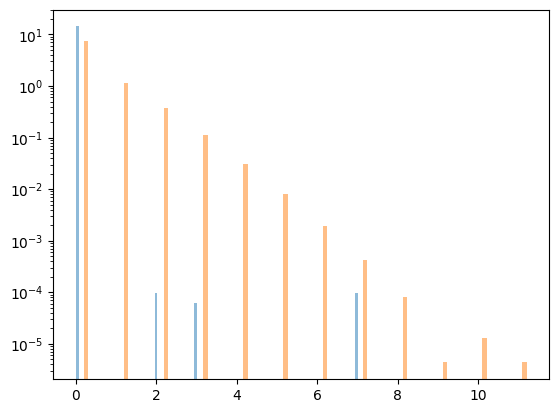

In [16]:
# model_Ntot
# base_dist_Ntot
# 203968/1817977 
cond_out = model.conv_layers(cond_tensor_jd[0])
cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# if self.sep_Ntot_cond:
cond_out_Ntot = model.cond_Ntot_layer(cond_out)

Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
Ntot_samp = np.maximum(np.round(Ntot_samp_tensor.cpu().detach().numpy()) - 1, 0).astype(int)
pl.figure()
_ = pl.hist(Ntot_samp, bins=100, density=True, alpha=0.5)
_ = pl.hist(0.2+Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
pl.yscale('log')



In [ ]:
# # model_Ntot
# # base_dist_Ntot
# # 203968/1817977 
# cond_out = model.conv_layers(cond_tensor_jd[0])
# cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# # if self.sep_Ntot_cond:
# # cond_out_Ntot = model.cond_Ntot_layer(cond_out)
# cond_inp_M1 = torch.cat([Nhalos_truth_tensor_jd[0], cond_out], dim=1)
# cond_inp_M1 = torch.cat([cond_inp_M1, X_M1_FP_jd[0]], dim=1)
# cond_inp_M1 = torch.cat([cond_inp_M1, mask_tensor_M1_train_FP_jd[0][:,None]], dim=1)
# cond_inp_M1 = model.cond_M1_layer(cond_inp_M1)

# # Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
# M1_samp, _ = model.M1_model.inverse(cond_inp_M1, mask_tensor_M1_samp)

# Ntot_samp = np.maximum(np.round(Ntot_samp_tensor.cpu().detach().numpy()) - 1, 0).astype(int)
# pl.figure()
# _ = pl.hist(Ntot_samp, bins=100, density=True, alpha=0.5)
# _ = pl.hist(0.2+Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# pl.yscale('log')



In [8]:
# # for jf in range(7):
# #     save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
# #     bestfit_model = (torch.load(save_bestfit_model_name))
# #     loss_min = bestfit_model['loss_min']
# #     print(loss_min)

# num_cond_Ntot = num_cond

# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_all_it = []
# loss_min = 1e20
# epoch_tot_counter = 0
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)

# save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(0)
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# # loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']


In [9]:
print(loss)


tensor([-1.2101], device='cuda:0', requires_grad=True)


In [10]:
# print('loading bestfit model')
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']
# lr = bestfit_model['lr']
# epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr

# print(loss_min, epoch_tot_counter, lr)




In [20]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

print(loss_min, epoch_tot_counter, stype)

train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 0, 0
isim_start = 1
isim_end = 2
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 512
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test, _ = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
        stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr
        )

    if cond_sim == 'fastpm':
        df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP, _ = load_density_halo_data_NGP(
            [isim], ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',
            stype=stype
            )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    # nfeatures_M1_tot = 20
    # cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
            )
        
        if cond_sim == 'fastpm':
            return_dict_test_FP = prep_density_halo_cats(
                df_d_all_test_FP,
                df_d_all_nsh_test_FP,
                df_Mh_all_test_FP,
                df_Nh_test_FP,
                nsims=nsims_test,
                nstart=nscount,
                Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
                )    

        if cond_sim == 'fastpm':
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        else:
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)

        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        
        if cond_sim == 'fastpm':
            mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
            # mask_tensor_Mdiff_test_FP = torch.Tensor(
            #     (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            #     ).cuda(dev)

            X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
            X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
            # X_Mdiff_test_FP = torch.Tensor(
            #     return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            #     ).cuda(dev)
            Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                            1)))).cuda(dev)
        else:
            mask_tensor_M1_test_FP = None
            mask_tensor_Mdiff_test_FP = None
            X_M1_test_FP = None
            X_Nhalo_test_FP = None
            X_Mdiff_test_FP = None
            Nhalos_truth_tensor_test_FP = None

        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h_subvol = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h_subvol['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h_subvol['N_halos']

    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    df_h_full = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array(np.arange(Nmax + 1))
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all
    print(hist_samp_all)
    print(hist_truth_all)

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(lgMmin, lgMmax, 20)[1:-1]
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high

    # # import pdb; pdb.set_trace()

    # # create empty arrays for Nhalos and M_halos
    # Nhalos = np.zeros((ns_h, ns_h, ns_h))
    # M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    # M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    # subvol_size = ns_h // nb

    # ind_cart_lin = {}
    # ind_lin_cart = {}
    # jc = 0
    # from tqdm import tqdm
    # for jx in tqdm(range(nb)):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             # get the sub-cube
    #             ind_lin_cart[(jx, jy, jz)] = jc
    #             ind_cart_lin[jc] = [jx, jy, jz]
    #             jc += 1
                

    # # iterate over subvolumes
    # jc = 0
    # for jx in range(nb):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                 jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

    #             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
    #             jc += 1
                
                
    
    # # create empty arrays for Nhalos and M_halos
    # Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    # M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    # subvol_size = ns_h // nb

    # ind_cart_lin = {}
    # ind_lin_cart = {}
    # jc = 0
    # from tqdm import tqdm
    # for jx in tqdm(range(nb)):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             # get the sub-cube
    #             ind_lin_cart[(jx, jy, jz)] = jc
    #             ind_cart_lin[jc] = [jx, jy, jz]
    #             jc += 1
                

    # # iterate over subvolumes
    # jc = 0
    # for jx in range(nb):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                 jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

    #             M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                     jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
                
                
    #             jc += 1
                

    # # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # dx = (xall[1] - xall[0])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    # x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    # k = 0
    # for jx in range(ns_h):
    #     for jy in range(ns_h):
    #         for jz in range(ns_h):
    #                 Nh_vox = int(Nhalos[jx, jy, jz])
    #                 if Nh_vox > 0:
    #                     x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
    #                     lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
    #                     k += Nh_vox

    # # convert to numpy arrays
    # x_h_mock = np.concatenate(x_h_mock)
    # y_h_mock = np.concatenate(y_h_mock)
    # z_h_mock = np.concatenate(z_h_mock)
    # pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    # lgMass_mock = np.concatenate(lgM_mock)
    # # convert to float data type
    # pos_h_mock = pos_h_mock.astype('float32')
    # lgMass_mock = lgMass_mock.astype('float32')


    # # sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # # # load the halo data
    # # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    # # df_h = pk.load(open(fname, 'rb'))
    # # # This has information on the halo mass for all the halos in the voxel
    # # df_Mh_all_truth = df_h['M_halos']
    # # df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # # # This has information on the number of halos in the voxel
    # # df_Nh_truth = df_h['N_halos']

    # # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_full_res_' + str(ns_h) + '_z=0.pk'
    # # df_h = pk.load(open(fname, 'rb'))
    # # df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # dx = (xall[1] - xall[0])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    # x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    # for jx in range(ns_h):
    #     for jy in range(ns_h):
    #         for jz in range(ns_h):
    #                 Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
    #                 if Nh_vox > 0:
    #                     x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
    #                     lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # # convert to numpy arrays
    # x_h_truth = np.concatenate(x_h_truth)
    # y_h_truth = np.concatenate(y_h_truth)
    # z_h_truth = np.concatenate(z_h_truth)
    # pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    # lgMass_truth = np.concatenate(lgM_truth)
    # # convert to float data type
    # pos_h_truth = pos_h_truth.astype('float32')
    # lgMass_truth = lgMass_truth.astype('float32')

    # grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    # BoxSize = 1000.0 #Mpc/h ; size of box
    # MAS     = 'NGP'  #mass-assigment scheme
    # verbose = True   #print information on progress

    # # Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    # # Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
    # Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
    # Mmax_Pk_all = np.log10(np.array([1e16, 7e13, 1e14, 5e14, 1e15]))    

    # saved_Pk_Bk = {}

    # for j in range(len(Mmin_Pk_all)):
    #     saved_j = {}
    #     Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
    #     indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    #     mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    #     pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    #     MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
    #     mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    #     Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

    #     indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    #     mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    #     pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    #     MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
    #     mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    #     Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

    #     Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

    #     saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
    #     saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
    #     saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
    #     saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

    #     BoxSize = 1000.0 #Size of the density field in Mpc/h
    #     threads = 1
    #     theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
    #     saved_j['theta'] = theta

    #     k1 = 0.03
    #     k2 = 0.03
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p03  = BBk.B     #bispectrum
    #     Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p03  = BBk.B     #bispectrum
    #     Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
    #     saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
    #     saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
    #     saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


    #     k1 = 0.06
    #     k2 = 0.06
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p06  = BBk.B     #bispectrum
    #     Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p06  = BBk.B     #bispectrum
    #     Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    #     saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    #     saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    #     saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    #     k1 = 0.1
    #     k2 = 0.1
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p1  = BBk.B     #bispectrum
    #     Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p1  = BBk.B     #bispectrum
    #     Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
    #     saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
    #     saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
    #     saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


    #     k1 = 0.2
    #     k2 = 0.2
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p2  = BBk.B     #bispectrum
    #     Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p2  = BBk.B     #bispectrum
    #     Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    #     saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    #     saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    #     saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    #     k1 = 0.3
    #     k2 = 0.3
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p3  = BBk.B     #bispectrum
    #     Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p3  = BBk.B     #bispectrum
    #     Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    #     saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    #     saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    #     saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    #     # k1 = 0.4
    #     # k2 = 0.4
    #     # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_truth_k0p4  = BBk.B     #bispectrum
    #     # Qk_truth_k0p4  = BBk.Q     #reduced bispectrum
    #     # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_mock_k0p4  = BBk.B     #bispectrum
    #     # Qk_mock_k0p4  = BBk.Q     #reduced bispectrum

    #     # saved_j['Bk_truth_k0p4'] = Bk_truth_k0p4
    #     # saved_j['Qk_truth_k0p4'] = Qk_truth_k0p4
    #     # saved_j['Bk_mock_k0p4'] = Bk_mock_k0p4
    #     # saved_j['Qk_mock_k0p4'] = Qk_mock_k0p4
    
    #     saved_Pk_Bk[j] = saved_j

    # saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '/'
    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '/'    
    # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '_wL2norm_highknots' + '/'    
    # # print(sdir)
    # # # make directory if doesn't exist:
    # # if not os.path.exists(sdir):
    # #     os.makedirs(sdir)
    # # import pickle as pk
    # # fname = sdir + '/summary_stats_jsim_' + str(isim) + '.pk'
    # # pk.dump(saved_all_jsim, open(fname, 'wb'))

                    








0.4250197410583496 5000 uniform_cic
DOING SIM NUMBER:1
[1730211  256729   78552   23130    6386    1671     370      76      21
       0       3       3]
[1727358  258423   79364   23661    6363    1535     355      79      10
       2       2       0]


In [51]:
# # model_Ntot
# # base_dist_Ntot
# # 203968/1817977 
# cond_out = model.conv_layers(cond_tensor_jd[0])
# cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# # if self.sep_Ntot_cond:
# cond_out_Ntot = model.cond_Ntot_layer(cond_out)

# Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
# pl.figure()
# _ = pl.hist(Ntot_samp_tensor.cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# _ = pl.hist(Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# pl.yscale('log')


In [52]:
# Nhalos_truth_tensor_jd.shape

In [21]:
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline




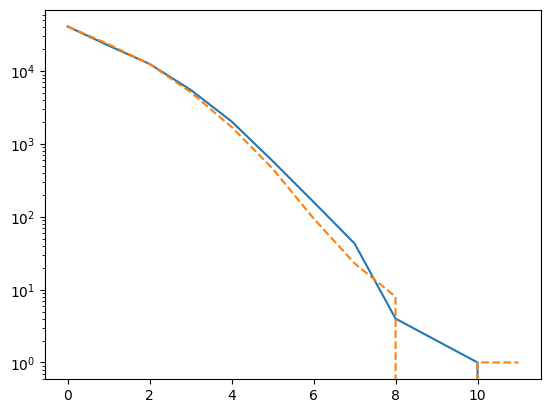

In [22]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_high_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo'], ls='--')
pl.yscale('log')




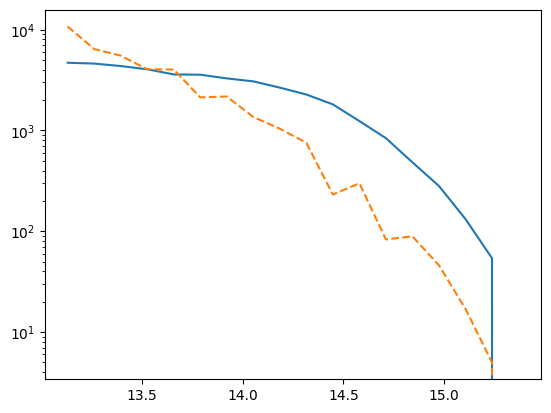

In [24]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_high_Mhalo'][0,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][0,:], ls='--')
pl.yscale('log')




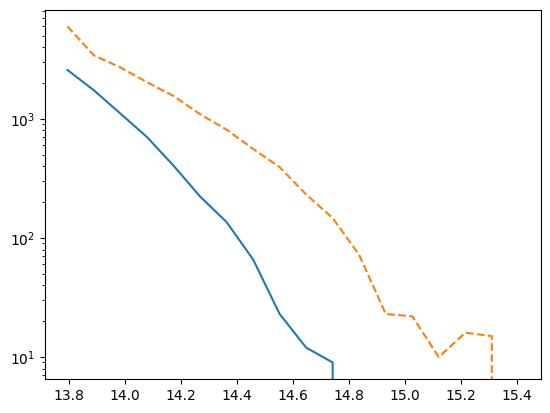

In [27]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][1,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][1,:], ls='--')
pl.yscale('log')




In [15]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h_subvol = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h_subvol['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h_subvol['N_halos']

fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h_full = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']



In [16]:
df_Mh_all_truth_comb.shape

(128, 128, 128, 4)

In [17]:
df_Mh_all_truth.shape


(512, 16, 16, 16, 4)

In [14]:
fname


'/mnt/home/spandey/ceph/Quijote/data_NGP_self/1/halos_fof_lgMmincut_5e13_full_res_128_z=0.pk'